Note:

Dropped  the timestamps, we only use indexes.
This also removed the large holes in the dataset, and data is not filled in anymore.

I have seen a lot of steps without lots of movement of the buy price. I then resampled the data to 1 hour intervals by using the median of every 12 steps.

**interesting enough, this has helped a lot of bringing in movement in the forecast**

why this is helping im not sure, maybe it trains the model to assume more movement than there really is?

In [6]:
%load_ext dotenv
%reload_ext dotenv
%dotenv

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [7]:
from darts.models import LightGBMModel
import pandas as pd
import numpy as np
import matplotlib

In [8]:
# Download source data from s3
from ml.common.folder_s3_sync import download_folder_from_s3

datapath = "../../../data/train_lightgbm/gw2/"


download_folder_from_s3(s3_folder_prefix='datasources/gw2/raw/1763399444', local_folder=datapath)

df = pd.read_csv(f'{datapath}Copper Ore.csv', delimiter=";")


Source: ost-s3/datasources/gw2/raw/1763399444
Target: ../../../data/train_lightgbm/gw2/

Found 60 files to download

⊘ +1 Agony Infusion.csv (already exists, ETag matches)
⊘ Auric Sliver.csv (already exists, ETag matches)
⊘ Bag of Coffee Beans.csv (already exists, ETag matches)
⊘ Bag of Sugar.csv (already exists, ETag matches)
⊘ Black Lion Chest.csv (already exists, ETag matches)
⊘ Bowl of Candy Corn Custard.csv (already exists, ETag matches)
⊘ Choya Spine.csv (already exists, ETag matches)
⊘ Congealed Putrescence.csv (already exists, ETag matches)
⊘ Copper Ore.csv (already exists, ETag matches)
⊘ Cup of Spiced Apple Cider.csv (already exists, ETag matches)
⊘ Elder Wood Log.csv (already exists, ETag matches)
⊘ Eye of Kormir.csv (already exists, ETag matches)
⊘ Flawless Snowflake.csv (already exists, ETag matches)
⊘ Fried Golden Dumpling.csv (already exists, ETag matches)
⊘ Glass of Buttered Spirits.csv (already exists, ETag matches)
⊘ Glob of Ectoplasm.csv (already exists, ETag matches

<Axes: xlabel='time'>

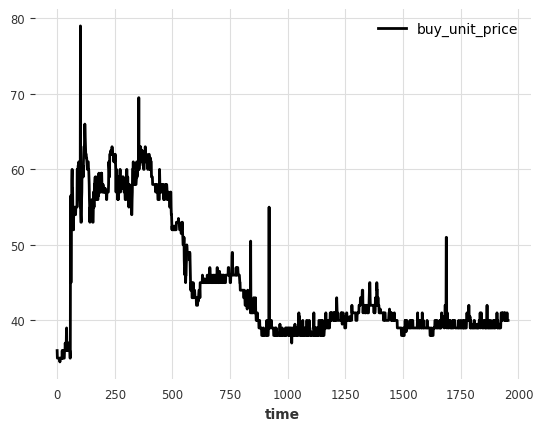

In [21]:
from darts import TimeSeries

def get_series_resampled(path, resample_interval):
    df = pd.read_csv(path, delimiter=";")
    value_cols = ["buy_unit_price"]

    tsdf = df[value_cols].copy()

    # Reset index to use integer index instead of timestamp
    tsdf = tsdf.reset_index(drop=True)

    resample_interval = 12
    tsdf = tsdf.groupby(tsdf.index // resample_interval).median()


    # Create TimeSeries with integer index
    series = TimeSeries.from_dataframe(tsdf, value_cols=value_cols)


    return series

sample = get_series_resampled(f"{datapath}Copper Ore.csv", resample_interval=12)

<Axes: xlabel='time'>

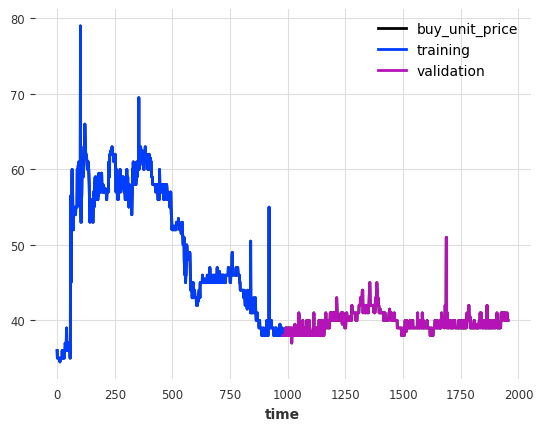

In [10]:
def train_val_split(series, split_percentage):
    train, val = series.split_after(split_percentage)
    return train, val

samples = get_series_resampled(f"{datapath}Copper Ore.csv", resample_interval=12)
samplet, samplev = train_val_split(samples, split_percentage=0.5)
samplet.plot(label="training")
samplev.plot(label="validation")

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 10743
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 256
[LightGBM] [Info] Using GPU Device: gfx1151, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 256 dense feature groups (0.26 MB) transferred to GPU in 0.001147 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 45.921727
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 10743
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 256
[LightGBM] [Info] Using GPU Device: gfx1151, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info

2025/11/20 21:03:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/20 21:03:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/20 21:03:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MAPE: 2.21%
RMSE: 1.31
MAE: 0.88
🏃 View run lightgbm_manual at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/9/runs/3244634910634fad9335033352b82c23
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/9


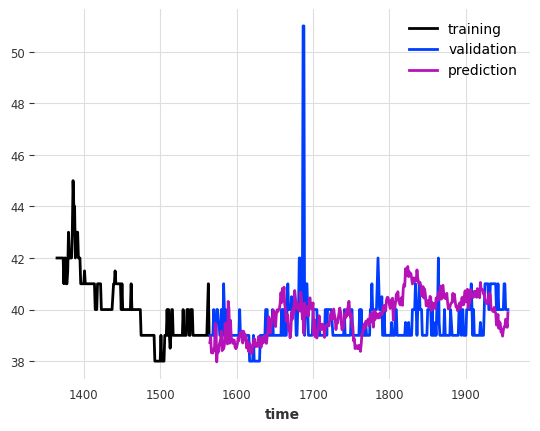

In [22]:
import tempfile
# Train model
from darts.models import LightGBMModel
from darts.metrics import mape, rmse, mae
import mlflow
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')

mlflow.set_experiment("lightgbm")

with mlflow.start_run(run_name="lightgbm_manual"):
    #prediction_horizon = 256
    resample_interval = 12
    split_percentage = 0.8
    item = "Copper Ore.csv"
    series_sampled = get_series_resampled(f"{datapath}{item}", resample_interval=resample_interval)
    train, val = train_val_split(series_sampled, split_percentage)
    prediction_horizon = len(val)

    model_params = {
        "lags": 256,
        "lags_past_covariates": None,
        "lags_future_covariates": None,
        "output_chunk_length": 256,
        "force_row_wise": True,
        "device": "gpu",
    }

    mlflow.log_params({
        "resample_interval": resample_interval,
        "train_test_split": split_percentage,
        "prediction_horizon": prediction_horizon,

        **model_params
    })





    model = LightGBMModel(**model_params)
    model.fit(train)

    # Make predictions

    pred = model.predict(n=prediction_horizon)

    # Calculate metrics
    val_short = val[:prediction_horizon]
    mape_score = mape(val_short, pred)
    rmse_score = rmse(val_short, pred)
    mae_score = mae(val_short, pred)

    # Log metrics
    mlflow.log_metrics({
        "mape": mape_score,
        "rmse": rmse_score,
        "mae": mae_score
    })

    with tempfile.TemporaryDirectory() as tmpdir:
        train.to_csv(f"{tmpdir}/train.csv")
        val.to_csv(f"{tmpdir}/val.csv")
        pred.to_csv(f"{tmpdir}/pred.csv")
        mlflow.log_artifacts(tmpdir, artifact_path="series")
        # Create and log the prediction plot
        fig, ax = plt.subplots(figsize=(12, 6))
        train[-200:].plot(label="training", ax=ax)
        val_short.plot(label="validation", ax=ax)
        pred.plot(label="prediction", ax=ax)
        ax.legend()
        ax.set_title("Model Predictions vs Actual Values")

        # Save and log the figure
        fig_path = f"{tmpdir}/prediction_plot.png"
        fig.savefig(fig_path, dpi=150, bbox_inches='tight')
        mlflow.log_artifact(fig_path, artifact_path="plots")
        plt.close(fig)


    # Log model
    mlflow.sklearn.log_model(model.model, "lightgbm_model")

    # Log additional info
    mlflow.set_tags({
        "dataset": "Copper Ore",
        "model_type": "LightGBM",
        "framework": "Darts"
    })

    print(f"MAPE: {mape_score:.2f}%")
    print(f"RMSE: {rmse_score:.2f}")
    print(f"MAE: {mae_score:.2f}")
    train[-200:].plot(label="training")
    val_short.plot(label="validation")
    pred.plot(label="prediction")

<Axes: xlabel='time'>

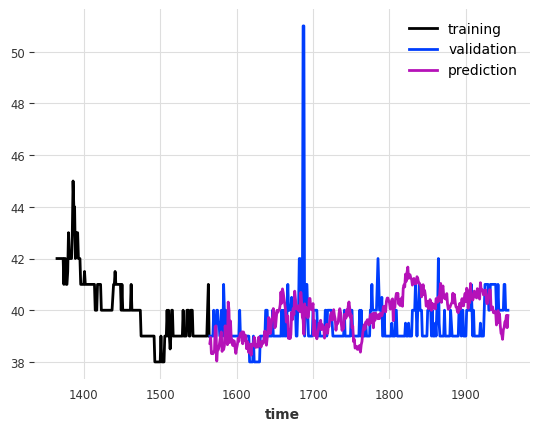

In [18]:
train[-200:].plot(label="training")
val_short.plot(label="validation")
pred.plot(label="prediction")